# Weakly Supervised Semantic segmentation

В контексте данной задачи мы учим сегментационную модель, не используя четкую разметку масок. У нас может ее не быть по многим причинам, но самая частая - дорогая разметка (разметка сегментации одна из самых дорогих). Поэтому мы можем использовать разметку другого формата - маска, но нечеткая (например полигоны с несколькими вершинами); ограничевающий прямоугольник (bounding box); центральная точка обьектов или метки класса (image label).

Cхематично получается вот так:

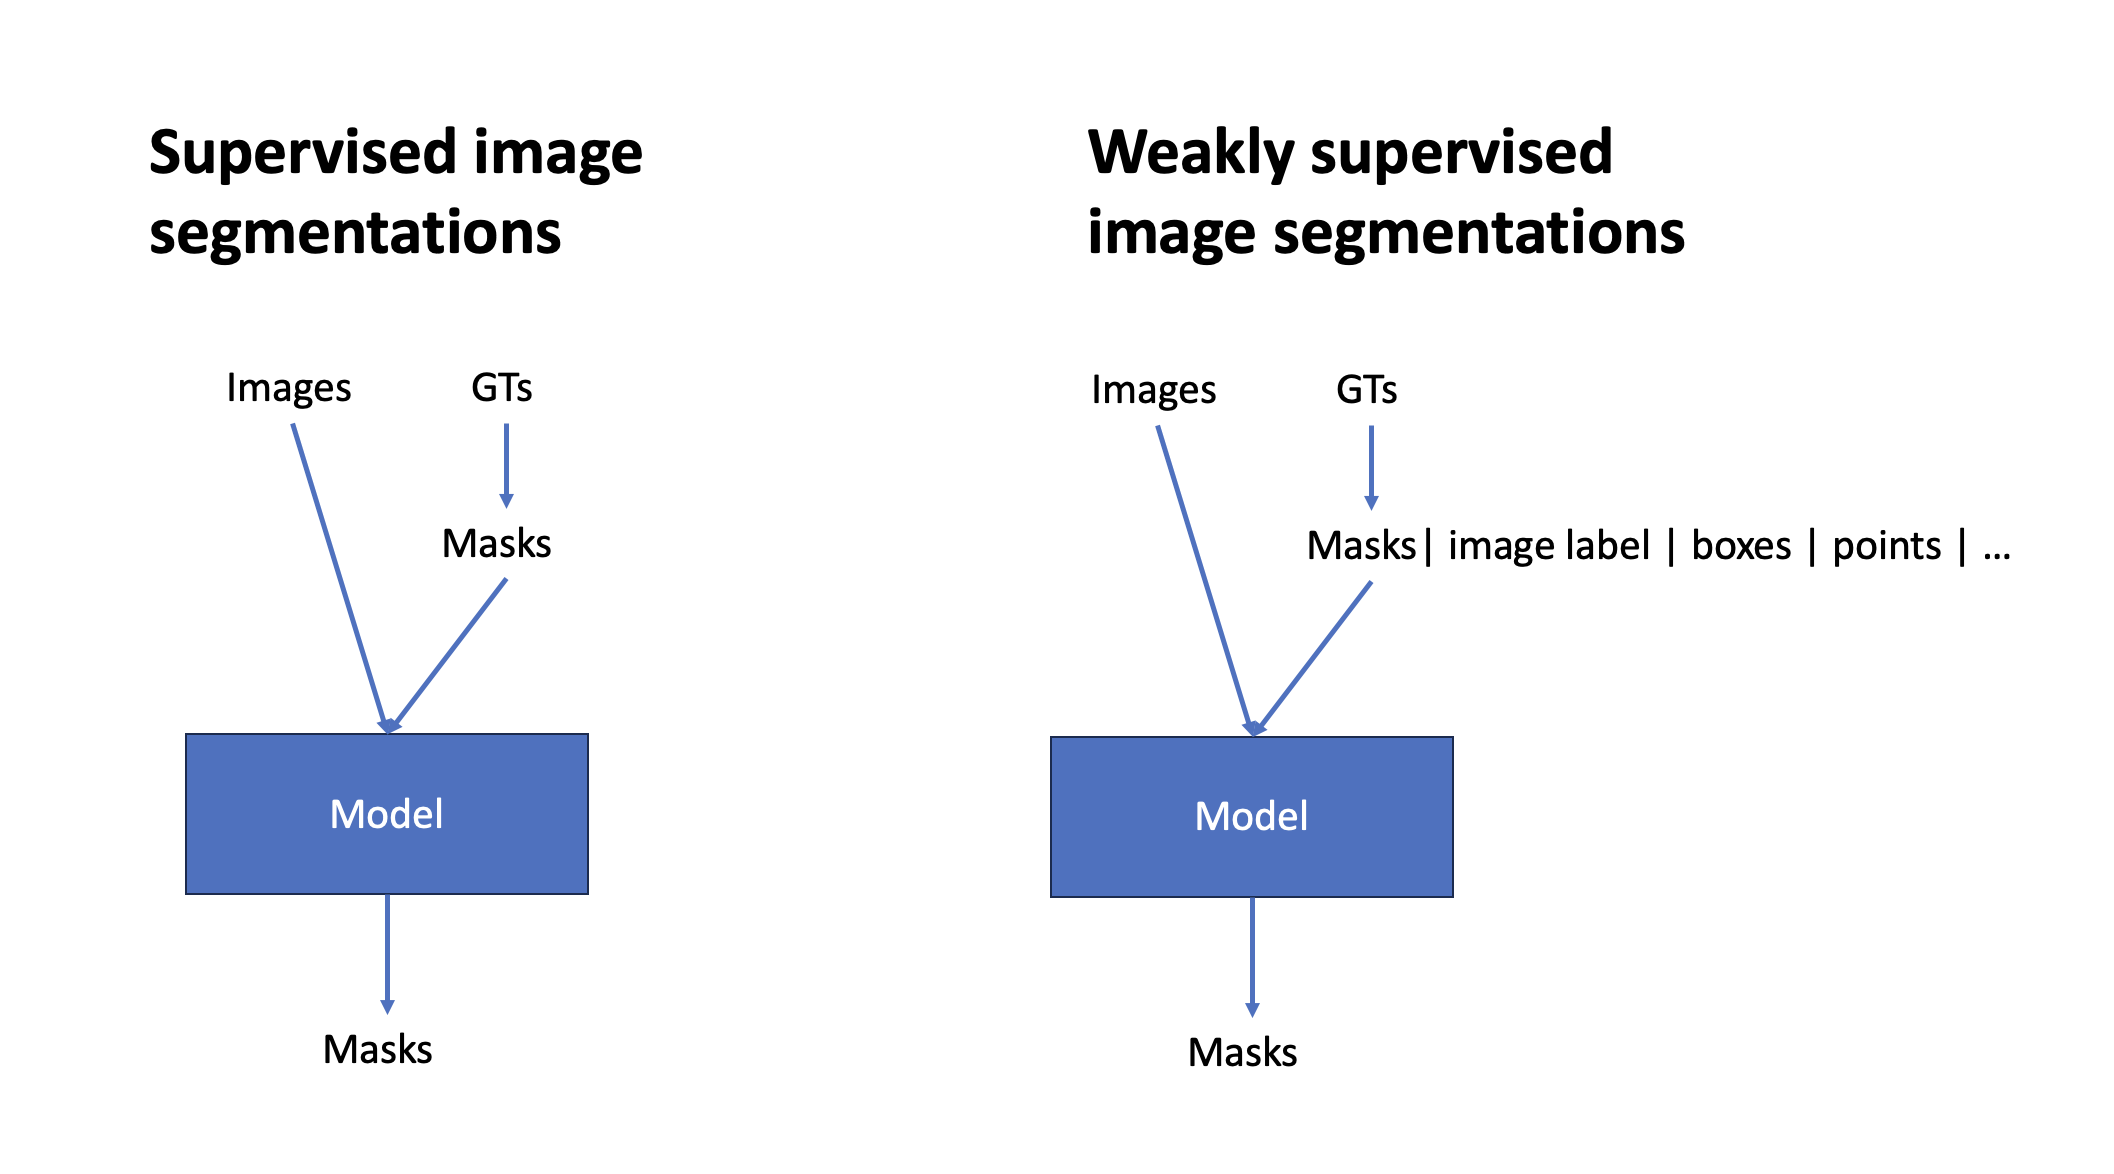

И часто бывает так, что вам известны только **image label**. То есть метки искомого класса (для которого надо учить маски). Ну и схематично это будет выглядить вот так:

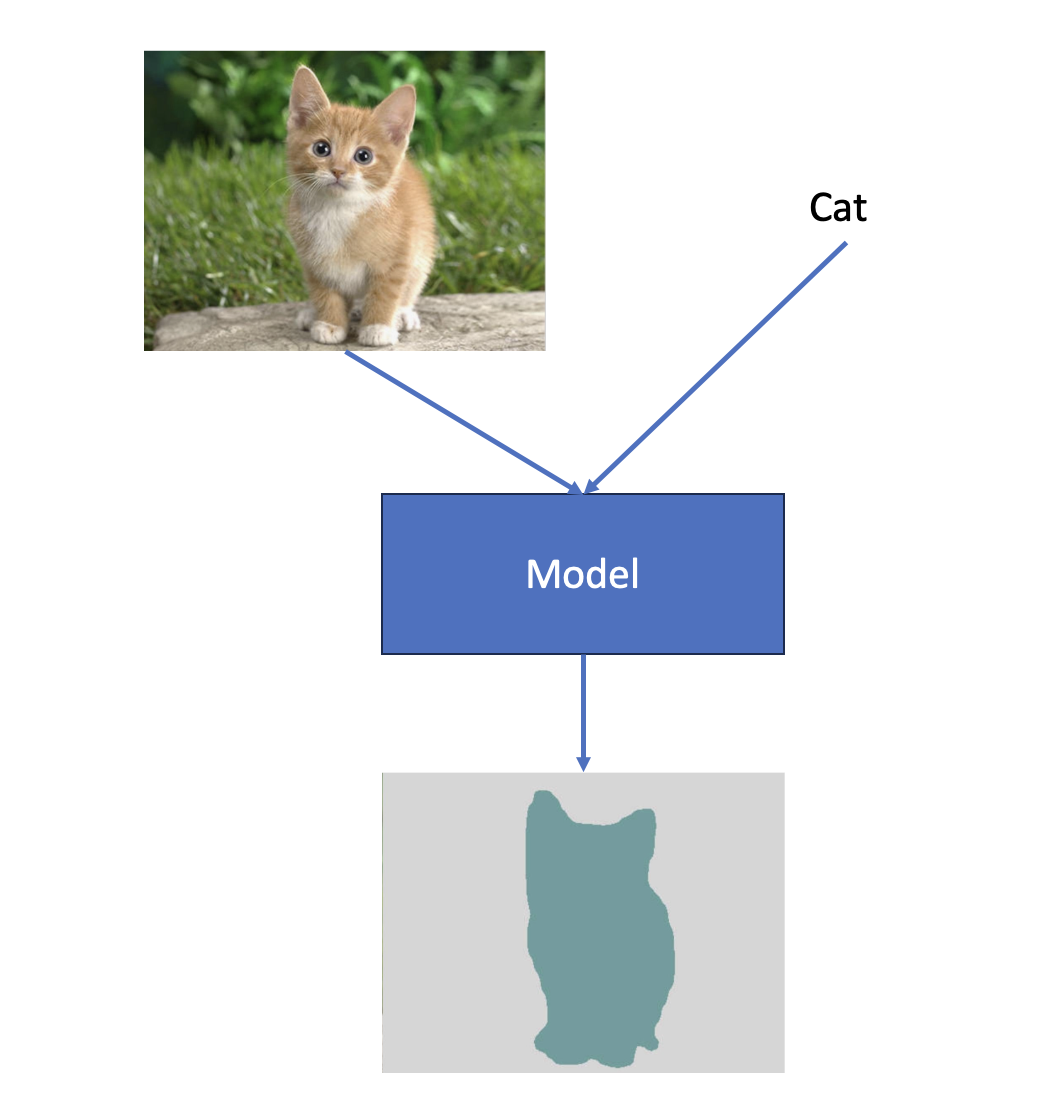

## Формулировка задачи

**Дано**: у Вас есть набор изображений определенного класса и мы точно знаем, что эти картинки принадлежат этому классу.

**Задача**: обучить модель, которая умеет сегментировать данного класса. То есть учим семантический сегментатор.

--------------------

И перед тем как листать дальше, подумайте как можно ее решить. Для начала попробуйте ответить на вопрос - а как достать хоть какую-нибудь разметку? На самом деле, в лекции есть ответ :)

### Нам повезло, сейчас у нас есть SAM :)

В оригинальной статье **SAM** можно использовать как **text promptable semantic segmentation model**. Это значит мы можем подать нашу метку класса в виде тестового промпта вида "все <class_name>" и тогда **SAM** разметит маски обьектов нужного класса.

Однако реализации с text prompt в открытом доступе нет. Поэтому необходимо полить другой промпт, так называемый sparse prompt - ббоксы или точки. Есть такая модель **gDino** - также foundation model, но для детекции. Она, спойлер, будет в следующей лекции, однако вот архитектура модель для понимания:

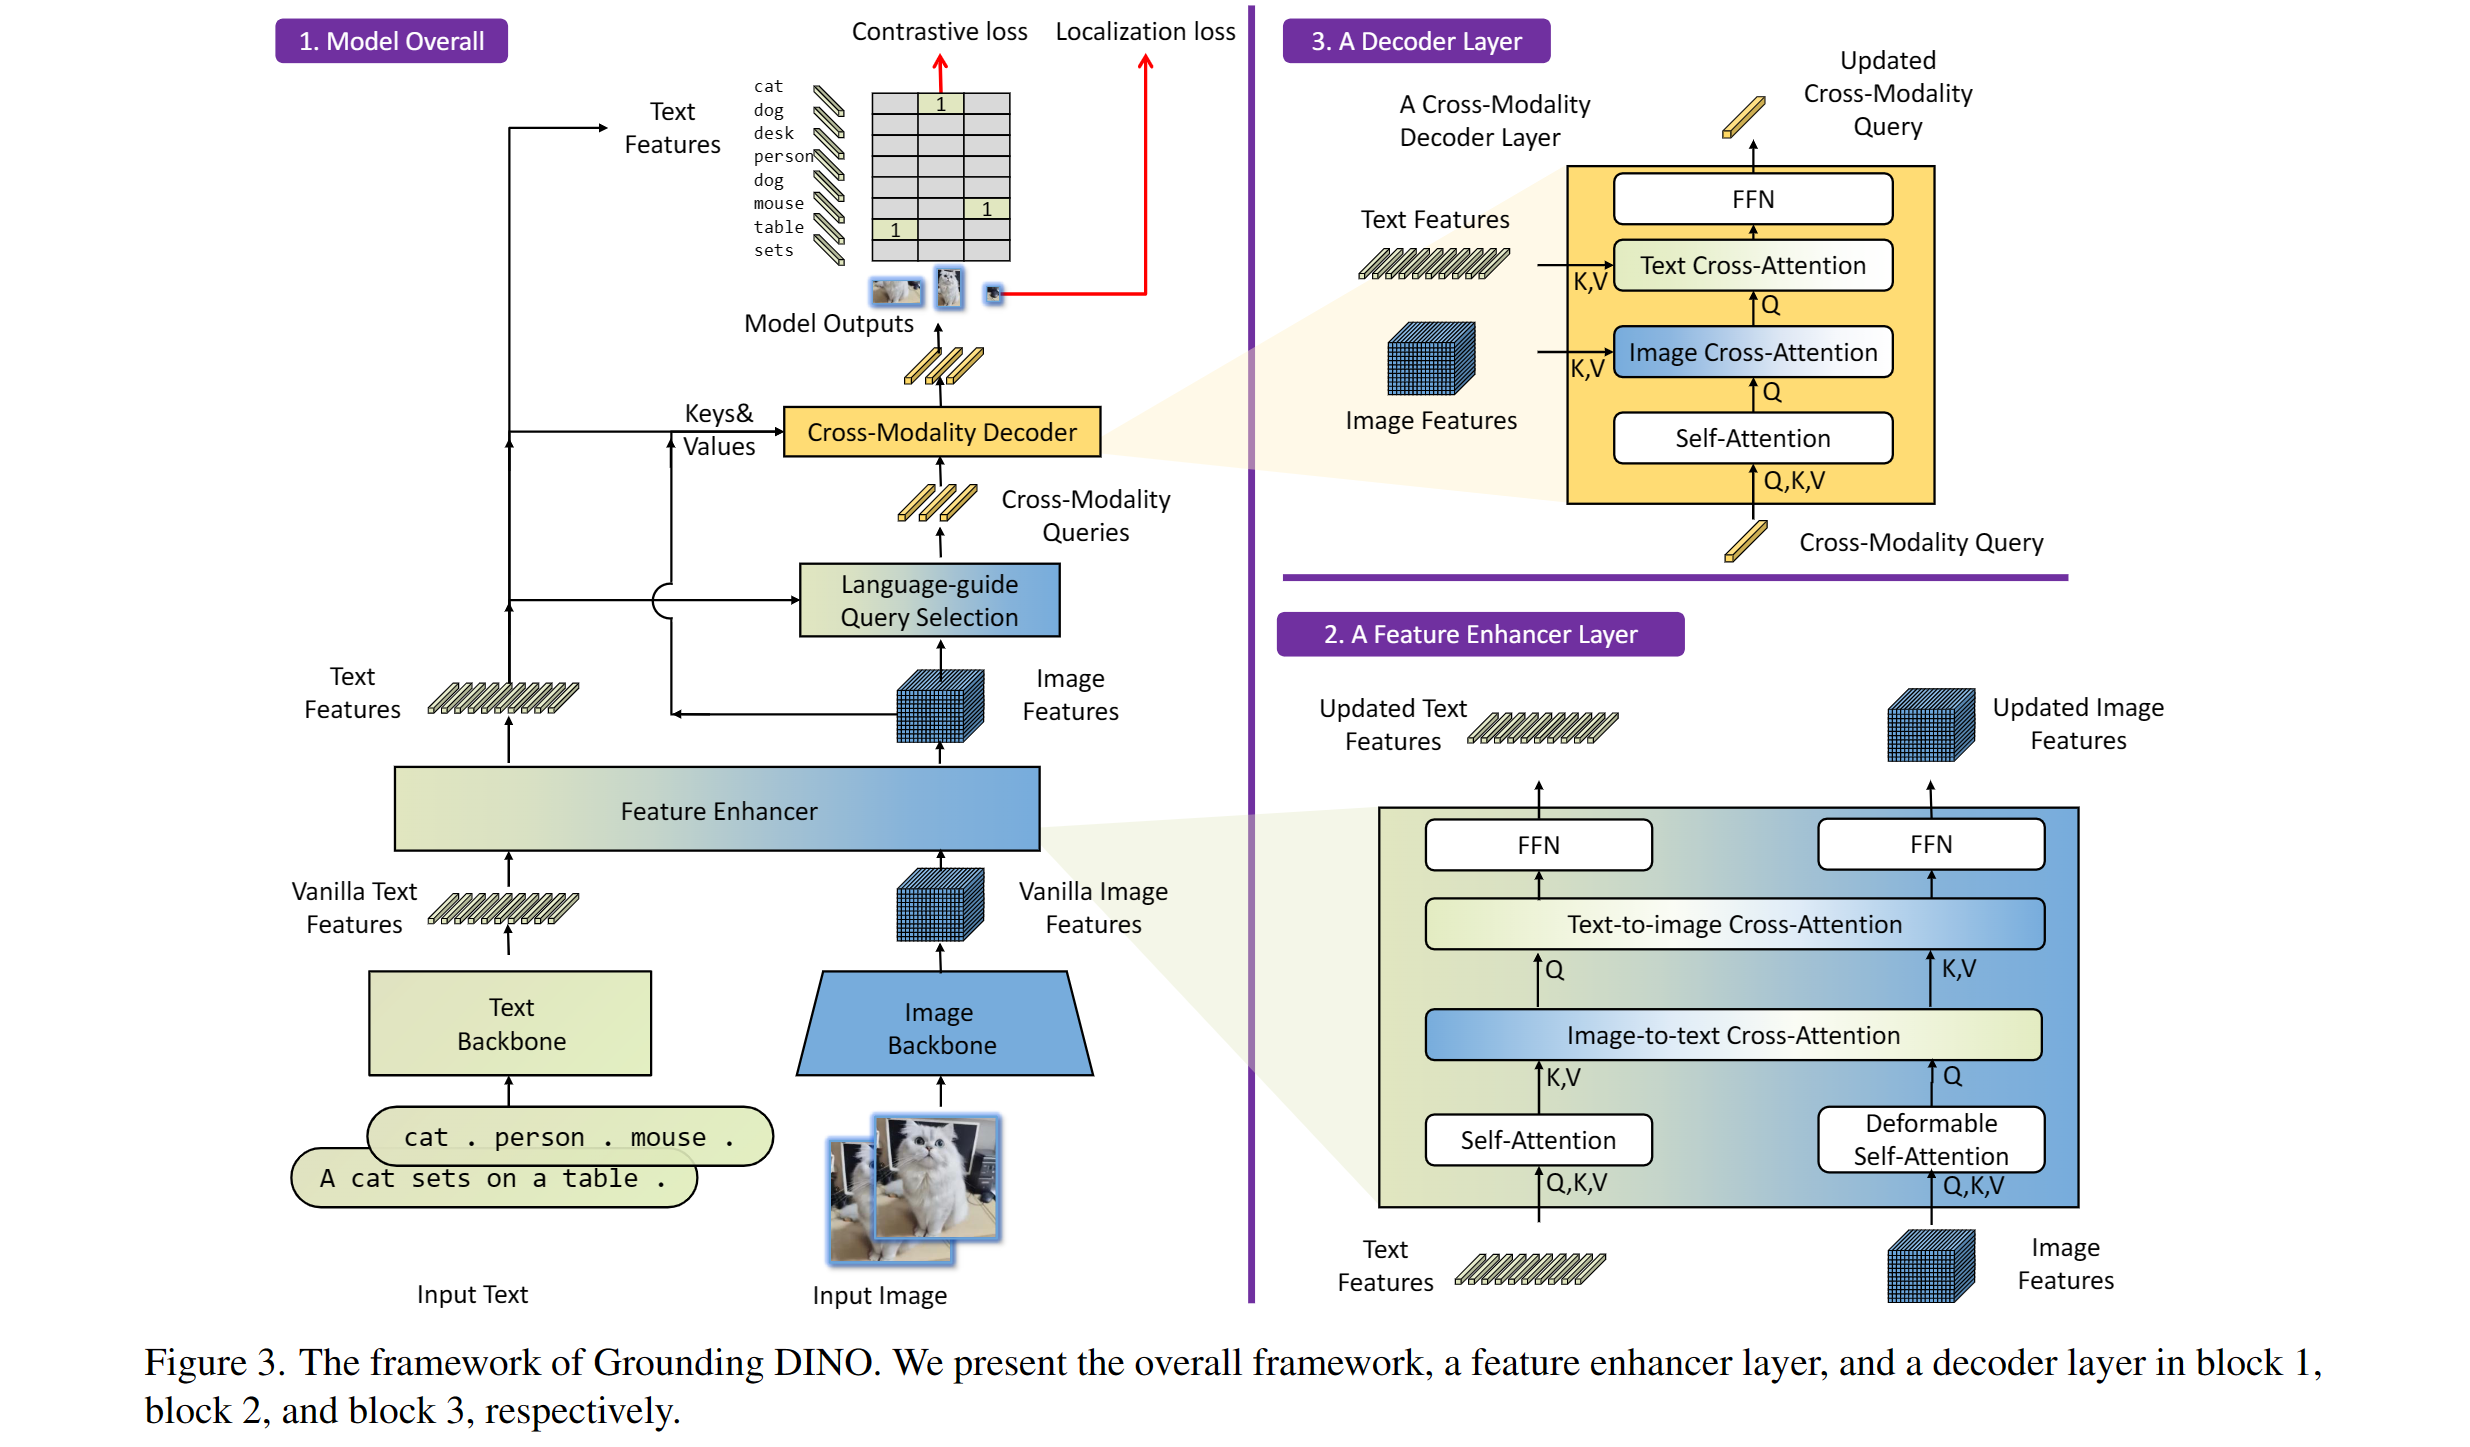

И да, мы будем ее использовать для получения sparse промпта под **SAM** из нашего текстового промпта :)

### Installation

Давайте установим все, для того, чтобы использовать SAM и gDINO.

In [ ]:
import os
import sys

HOME = os.getcwd()
print("HOME:", HOME)

%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!git checkout -q 57535c5a79791cb76e36fdb64975271354f10251
!pip install -q -e .

%cd {HOME}
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

GROUNDING_DINO_CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(GROUNDING_DINO_CONFIG_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CONFIG_PATH))
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
print(GROUNDING_DINO_CHECKPOINT_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CHECKPOINT_PATH))

%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(SAM_CHECKPOINT_PATH, "; exist:", os.path.isfile(SAM_CHECKPOINT_PATH))

In [ ]:
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Инициализация gDINO достаточно простая - в стиле всех трансформеров из huggingface - надо прокинуть веса модели и конфиг.

In [ ]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import Model

grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

Инициализация SAM еще проще, надо указать версию енкодера и веса всей модели. Мы берем самую большую версию - **VIT-H**.

In [ ]:
from segment_anything import sam_model_registry, SamPredictor
SAM_ENCODER_VERSION = "vit_h"
sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)

Для примера давайте возьмем картинку с курочками и попробуем найти маску куриц на ней. Да, спойлер, придется учить сегментатор куриц :)

In [ ]:
SOURCE_IMAGE_PATH = f"/kaggle/input/chickens/gallina/200.jpeg"
CLASSES = ['chicken']
BOX_TRESHOLD = 0.25 # порог по конфиденсу bounding box'а
TEXT_TRESHOLD = 0.25 # порог для соотвествия бокса и промпта

In [ ]:
from typing import List

def enhance_class_name(class_names: List[str]) -> List[str]:
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]

# функция которая просто генерирует промпты из меток класса, тут можно играться

In [ ]:
import cv2

# load image
image = cv2.imread(SOURCE_IMAGE_PATH)

# detect objects
detections = grounding_dino_model.predict_with_classes(
    image=image,
    classes=enhance_class_name(class_names=CLASSES),
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)
detections

Итак, ответом модели **gDINO** является обьект **Detections**, который содержит

- bounding boxes (ключ - **xyxy**) - массив координат левого верхнего угла и правого нижнего угла боксов
- вероятности боксов (ключ - **confidence**)
- индексы промптов, которым соответвует соотвуствующий бокс (ключ - **class_id**)

In [ ]:
import numpy as np
from segment_anything import SamPredictor


# функция для генерирования маски с помощью SAM и bounding bboxes как prompt

def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

In [ ]:
import cv2

# convert detections to masks
detections.mask = segment(
    sam_predictor=sam_predictor,
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    xyxy=detections.xyxy
)


In [ ]:
import matplotlib.pyplot as plt

plt.imshow(
    cv2.addWeighted(
        image, 0.3,
        np.repeat(detections.mask[0].astype(np.uint8)[..., np.newaxis], 3, 2) * 255, 0.7,
    0)
)

Вот и результат работы gDINO + SAM. Давайте теперь обьединим это в одну функцию:

In [ ]:
def chicken_marking(image):
    detections = grounding_dino_model.predict_with_classes(
      image=image,
      classes=enhance_class_name(class_names=['chicken']),
      box_threshold=0.25,
      text_threshold=0.25
    )
    detections.mask = segment(
      sam_predictor=sam_predictor,
      image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
      xyxy=detections.xyxy
    )
    return detections.mask.max(0).astype(np.uint8) * 255

In [ ]:
SOURCE_IMAGE_PATH = f"/kaggle/input/chickens/gallina/39.jpeg"
image = cv2.imread(SOURCE_IMAGE_PATH)

plt.imshow(
    cv2.addWeighted(
        image, 0.3,
        np.repeat(chicken_marking(image)[..., np.newaxis], 3, 2), 0.7,
    0)
)

Видно, что в целом SAM хорошо справляется с задачей. Он, очевидно, видел класс куриц в своей обучающей выборке и поэтому не испытывает трудностей. Однако все равно есть и будут артефакты (смотрите на правую курицу и ее маску) и это надо понимать.

А теперь давайте подумаем, что делать если у нас нету SAM или он тупо не справляется с нашей задачей как нам требуется...

## Решаем задачу без SAM

Давайте еще раз сформулируем задачу:

- У нас есть картинки, их порядка **3000**. Теперь зафиксируем класс этих картинок, мы его все равно знаем - это класс "**курица**".
- Нам необходимо обучить **модель сегментации**, которая будет сегментировать куриц на этих картинках. Но **у нас нет масок**, напоминаю.
- У нас есть 50-100 картинок, которые мы смогли разметить (сами или еще как-то) для того, отладить будущие решения. И давайте разметку получим с помощью SAM (но никому не говорите, у нас же нету SAM :) )
- И давайте предположим у нас есть **классификатор** (у нас же image label разметка есть, а это как раз классификационная разметка). Как получем классификатор в рамках этого семинара не важно, это может быть классификатор из **open source**, который обучался на выборке, содержащий класс куриц или это вами обученный классификатор на этом классе (например берете imagenet, добавляете ваш класс и тюните классификатор). Итак, самое главное, что ваш классификатор умеет понимать что такое курица :)

--------

Давайте возьмем классификатор из open source - resnet18 обученный на imagenet.



In [ ]:
from timm import create_model
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(),
    ToTensorV2()
])

classificator = create_model('resnet18.fb_ssl_yfcc100m_ft_in1k', pretrained=True).eval()

chicken_imagenet_class_idx = 8

In [ ]:
SOURCE_IMAGE_PATH = f"/kaggle/input/chickens/gallina/39.jpeg"
image = cv2.imread(SOURCE_IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

with torch.inference_mode():
    logits = classificator(transform(image=image)['image'].unsqueeze(0)).squeeze(0)
    probs = torch.softmax(logits, 0)
    print(probs[chicken_imagenet_class_idx])

Вот мы вывели вероятность класса 8 - класса куриц. Она очень высокая, что говорит о том, что модель понимает почему на этой картинке курица и это очень важно для последующих методов. А методы буду опираться именно на понимание сетки. А как мы понимаем как понимает сетка? - правильно через **Class Activation Maps**!

### GCAM - все (почти)  что нам нужно

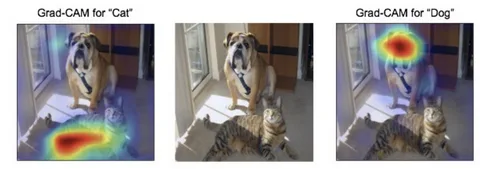

Давайте установим либу *grad-cam* для получения карты активаций нашего класса.

In [ ]:
!pip install grad-cam

И теперь получим эту карту. Она будет указывать на участки изображения, которые по мнению сетки важны.

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget



SOURCE_IMAGE_PATH = f"/kaggle/input/chickens/gallina/39.jpeg"
image = cv2.imread(SOURCE_IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
tensor = transform(image=image)['image'].unsqueeze(0)

with GradCAM(model=classificator, target_layers=[classificator.layer4[-1]]) as cam:
    grayscale_cam = cam(input_tensor=tensor, targets=[ClassifierOutputTarget(8)])
    grayscale_cam = grayscale_cam[0, :]

plt.imshow(grayscale_cam)

In [ ]:
mask = (grayscale_cam * 255).astype(np.uint8)
mask = cv2.resize(mask ,(image.shape[1], image.shape[0]))
plt.imshow(
    cv2.addWeighted(image, 0.3, np.repeat(mask[..., np.newaxis], 3, 2), 0.7, 0)
)

In [ ]:
# давайте отфильтруем матрицу CAM по порогу, например 0.3 (числа варьируются от 0 до 1)

mask = ((grayscale_cam > 0.3) * 255).astype(np.uint8)
mask = cv2.resize(mask ,(image.shape[1], image.shape[0]))
plt.imshow(
    cv2.addWeighted(image, 0.3, np.repeat(mask[..., np.newaxis], 3, 2), 0.7, 0)
)

Если честно, этого уже +- достаточно чтобы пробовать обучать сетку. Однако видно, что не все курицы попадают в нашу маску, которая получена из CAM, ну и много фонового шума.

-----

Подумайте как можно дешево учушить маску. Подсказываю - аугментации (но как это применять?)

### Аугментация для улучшения масок

In [ ]:
# давайте просто отзеркалим картинку по горизонтали и посмотрим какую карту CAM мы получим

SOURCE_IMAGE_PATH = f"/kaggle/input/chickens/gallina/39.jpeg"
image = cv2.imread(SOURCE_IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
tensor = transform(image=cv2.flip(image, 1))['image'].unsqueeze(0)

with GradCAM(model=classificator, target_layers=[classificator.layer4[-1]]) as cam:
    grayscale_cam = cam(input_tensor=tensor, targets=[ClassifierOutputTarget(8)])
    grayscale_cam = grayscale_cam[0, :]
    grayscale_cam = cv2.flip(grayscale_cam, 1)

mask = (grayscale_cam * 255).astype(np.uint8)
mask = cv2.resize(mask ,(image.shape[1], image.shape[0]))
plt.imshow(
    cv2.addWeighted(image, 0.3, np.repeat(mask[..., np.newaxis], 3, 2), 0.7, 0)
)

In [ ]:
mask = ((grayscale_cam > 0.3) * 255).astype(np.uint8)
mask = cv2.resize(mask ,(image.shape[1], image.shape[0]))
plt.imshow(
    cv2.addWeighted(image, 0.3, np.repeat(mask[..., np.newaxis], 3, 2), 0.7, 0)
)

Вот так, получается мы просто сделали флип картинки, а CAM получился другой, даже лучше. И это можно использовать, причем по-разному.

Давайте мы возьмем исходную картинку и перевернутую картинку. Найдем для каждой из них CAMы и обьединим результаты (берем обьединение, а не пересечение, чтобы всех куриц захватить). И вот мы получим новую маску, она, очевидно будет больше стандартной маски из CAM.

In [ ]:
def get_cam(image, mask_threshold=0.3):
    tensor = transform(image=image)['image'].unsqueeze(0)
    with GradCAM(model=classificator, target_layers=[classificator.layer4[-1]]) as cam:
        grayscale_cam = cam(input_tensor=tensor, targets=[ClassifierOutputTarget(8)])
        grayscale_cam = grayscale_cam[0, :]
        grayscale_cam = cv2.resize(grayscale_cam ,(image.shape[1], image.shape[0]))
        return ((grayscale_cam > mask_threshold) * 255).astype(np.uint8)


def get_tta_cam(image, mask_threshold=0.3):
    samples = [
      image,
      cv2.flip(image, 1)
    ]
    masks = []
    for sample in samples:
        masks.append(get_cam(sample, mask_threshold))

    masks[1] = cv2.flip(masks[1], 1)
    return np.maximum(*masks)

In [ ]:
SOURCE_IMAGE_PATH = f"/kaggle/input/chickens/gallina/39.jpeg"
image = cv2.imread(SOURCE_IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = get_tta_cam(image, 0.3)
plt.imshow(
    cv2.addWeighted(image, 0.3, np.repeat(mask[..., np.newaxis], 3, 2), 0.7, 0)
)

Вот теперь все курицы в маске) Очевидно, что можно использовать разные аугментации их комбинации их масок CAMов. В некоторых статьях берут флипы и повышение/понижение яркости/контраста. Но самое главное это работает. И давайте в этом убедимся, подсчитав какие-нибудь метрки

### Сравним методы численно

В semantic segmentation много метрик, однако очень важная и популярная - mean IOU. Она описывает способность вашего алгоритма предсказывать целевые маски и делает это путем усреднения по всем картинкам метрки IOU. Вот так она выглядит:

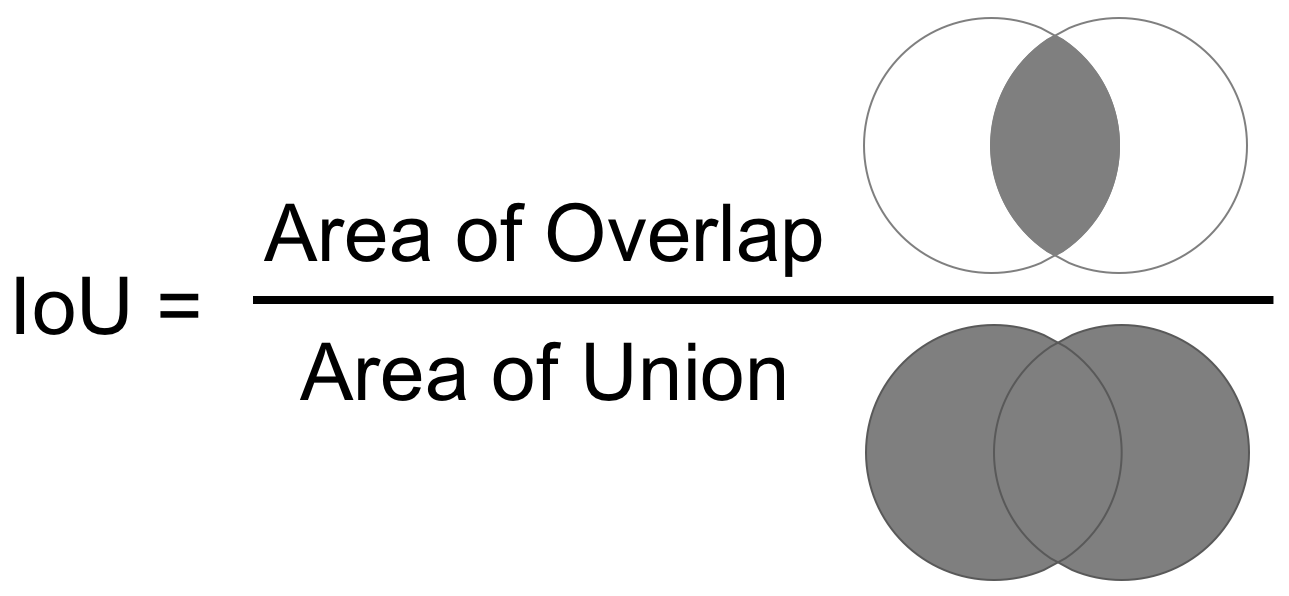

То есть мы берем предсказанную маску картинки и gt маску, считаем площадь их пересечения и площадь их обьединения и потом делим одно на другое. Значение IOU варьируется от 0 до 1.

Итак, напомню, что GT для 50 картинок мы можем получить с помощью SAM (нам просто лень самим размечать). И давайте посмотрим mean IOU между масками, полученных из CAM (предсказания масок по-сути) и масками полученных с помощью SAM (gt маски по-сути).

In [ ]:
from tqdm.notebook import tqdm
from pathlib import Path

def m_iou(preds, gts):
    iou = 0.0
    for pred, gt in zip(preds, gts):
        intersection = np.minimum(pred, gt).astype(np.bool_).sum()
        union = np.maximum(pred, gt).astype(np.bool_).sum()
        iou += intersection / union
    return iou / (len(preds) + 1e-9)

images_path = f'/kaggle/input/chickens/gallina'
image_paths = [x for x in Path(images_path).glob('**/*.jpeg')]
test_size = 50

gts, cam_masks, tta_cam_masks = [], [], []

for image_path in tqdm(image_paths[:test_size]):
    image = cv2.imread(image_path)
    gts.append(chicken_marking(image))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cam_masks.append(get_cam(image))
    tta_cam_masks.append(get_tta_cam(image))

In [ ]:
m_iou(cam_masks, gts), m_iou(tta_cam_masks, gts)

Вот, на 2 процента мы подняли качество наших масок, причем сделали это очень дешево.

------

В целом все это называется **coarse annotation**, когда ваши маски размечены нечетко. Вот пример такой разметки в датасете cityscapes:

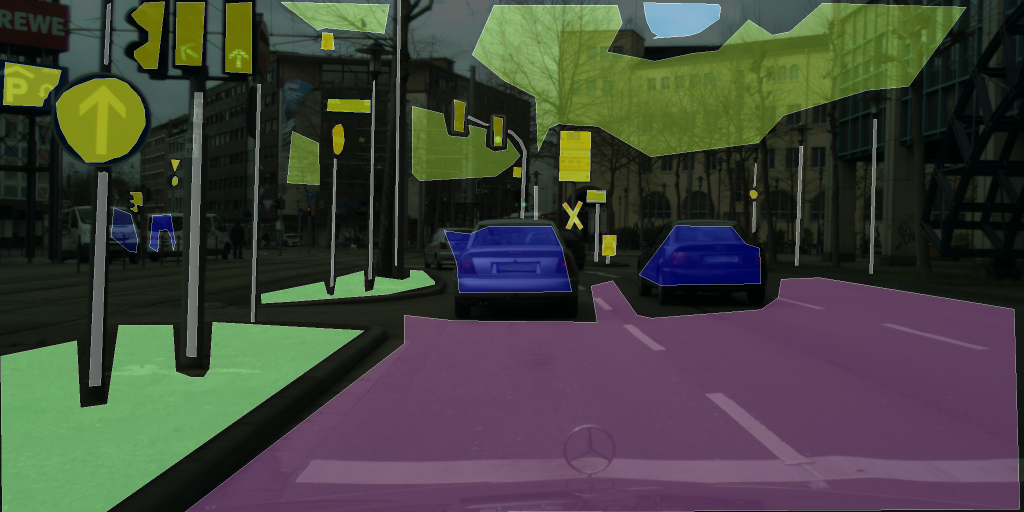

Но давайте не будем останавливаться :)

У нас осталась одна проблема - много фоновых пикслей мы помечаем как пиксель класса курицы. И да, мы можем решить эту проблему.

### Dense Conditional Random Field - выравнивает маски учитывая инфу с картинки

CRF - это оптимизационная задача, причем графовая. Мы не будем вдаваться в подробности, если хотите почитайте про нее в интернете. Однако главное понимать, что она берет на вход вашу маску и картинку и сопоставляет вашу маску с картинкой, учитывая пространственные взаимосвязи между пикселями куриц и сами значения этих пикслей. Результатом алгоритма будет новая маска, которая будет четче.

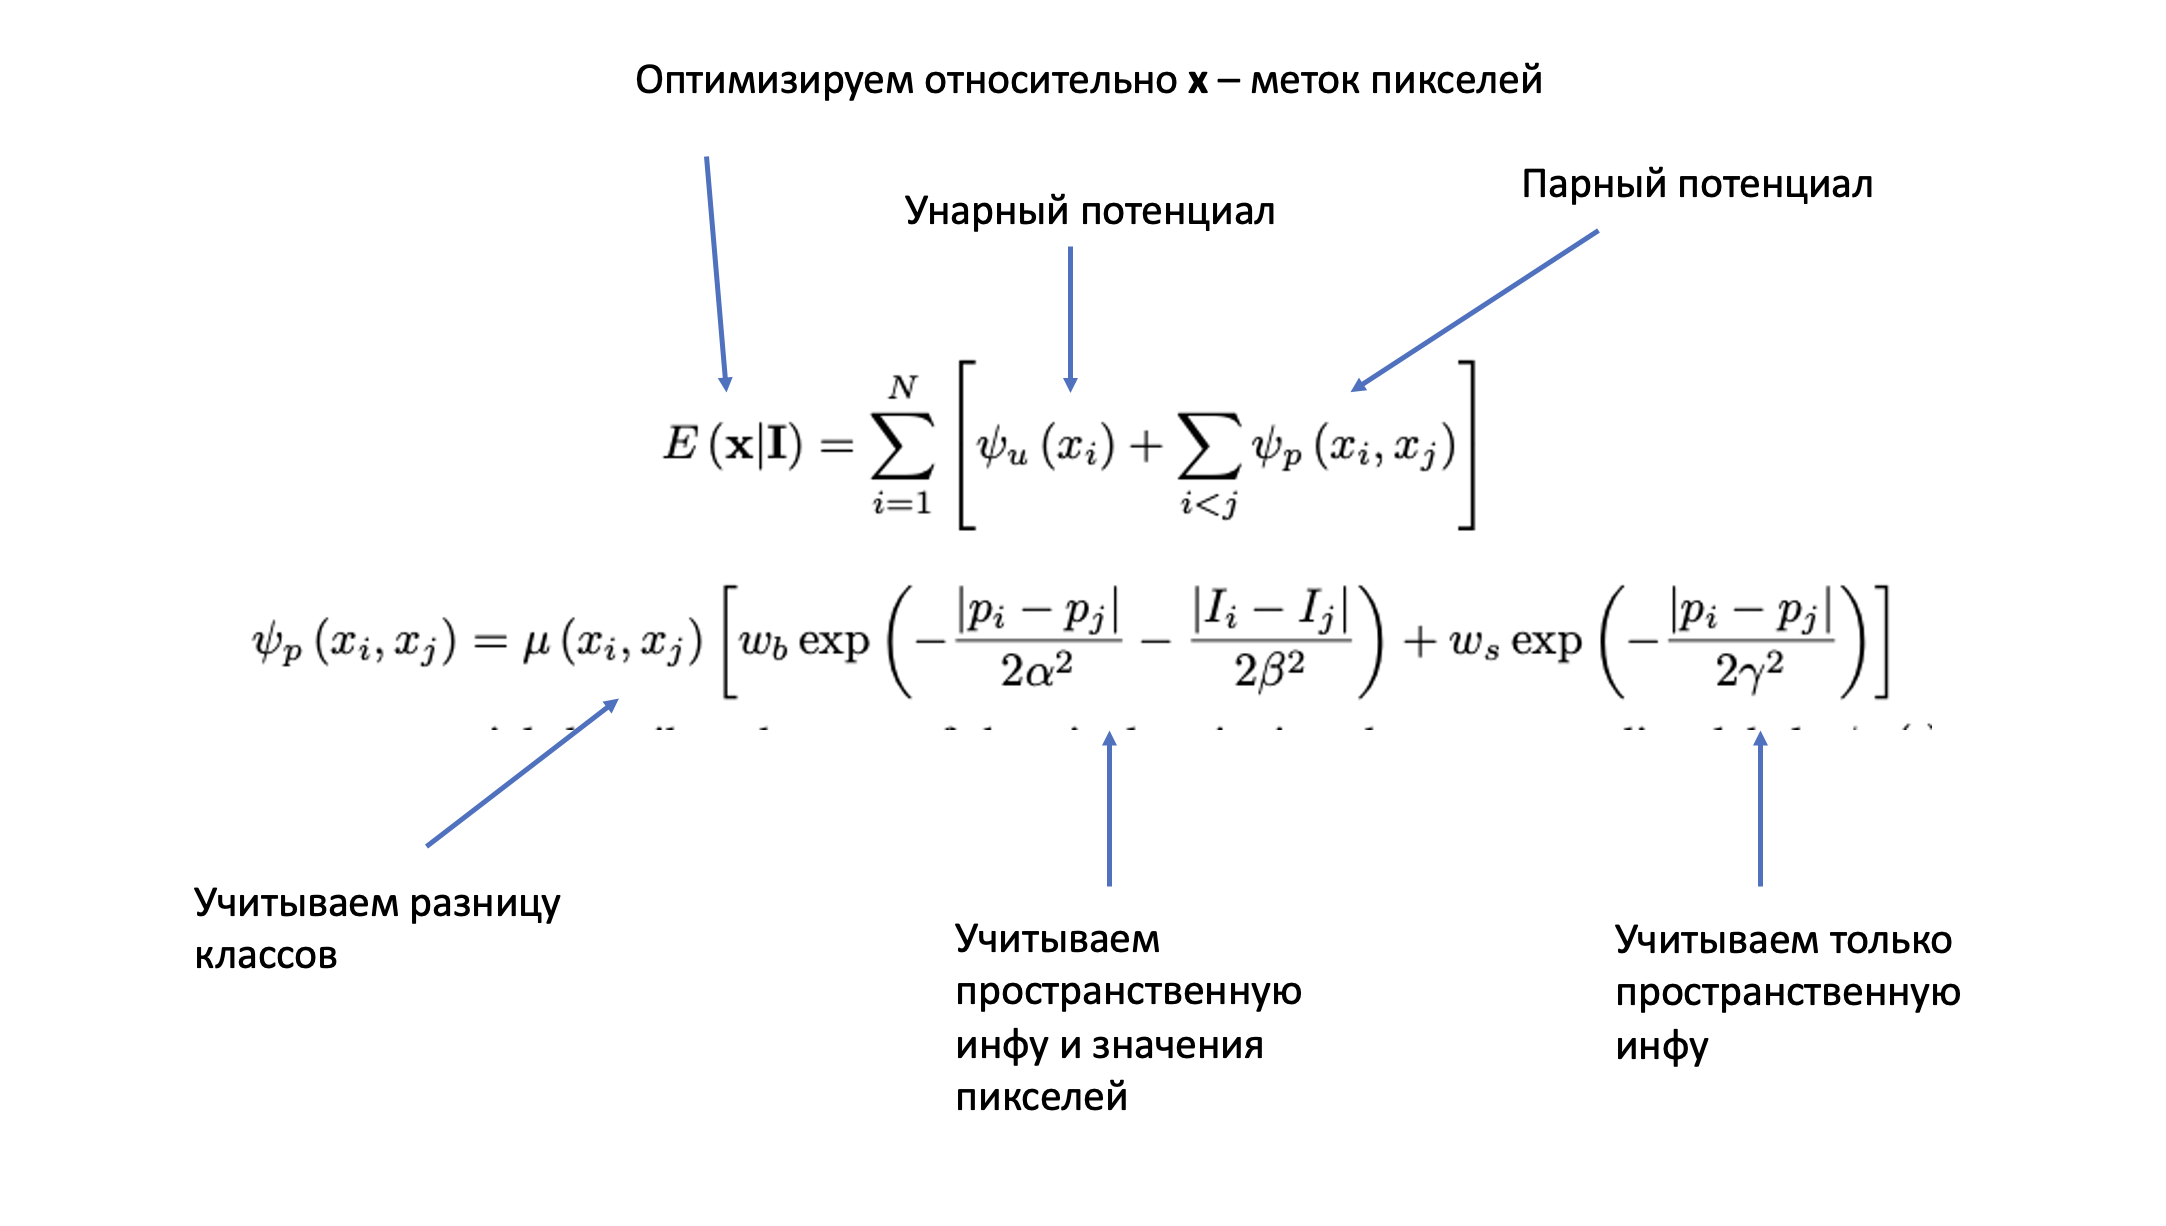

Для того, чтобы использовать этот алгоритм можно поставить пакет *pydensecrf*.

In [ ]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

In [ ]:
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral

Итак, еще раз посмотрим на маску из CAM.

In [ ]:
SOURCE_IMAGE_PATH = f"/kaggle/input/chickens/gallina/39.jpeg"
image = cv2.imread(SOURCE_IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = get_cam(image, 0.3)
plt.imshow(
    cv2.addWeighted(image, 0.3, np.repeat(mask[..., np.newaxis], 3, 2), 0.7, 0)
)

А теперь давайте применим алгоритм dense CRF для нашей маски и картинки

In [ ]:
tensor = transform(image=image)['image'].unsqueeze(0)
with GradCAM(model=classificator, target_layers=[classificator.layer4[-1]]) as cam:
    grayscale_cam = cam(input_tensor=tensor, targets=[ClassifierOutputTarget(8)])
    grayscale_cam = grayscale_cam[0, :]
    grayscale_cam = cv2.resize(grayscale_cam ,(image.shape[1], image.shape[0]))

In [ ]:
h, w = image.shape[:2]

d = dcrf.DenseCRF2D(w, h, 2)
softmax = np.repeat(grayscale_cam[np.newaxis, ...], 2, 0)
softmax[0, ...] = 1 - softmax[0, ...]
unary = unary_from_softmax(softmax.reshape((2,-1)))
d.setUnaryEnergy(unary)
unary

In [ ]:
d.addPairwiseGaussian(sxy=(3,3), compat=3, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
d.addPairwiseBilateral(
    sxy=(80,80),
    srgb=(13,13,13),
    rgbim=image,
    compat=10,
    kernel=dcrf.DIAG_KERNEL,
    normalization=dcrf.NORMALIZE_SYMMETRIC
)


In [ ]:
Q = d.inference(3)
aligned_mask = np.argmax(Q, axis=0).reshape(image.shape[:2])

plt.imshow(
    cv2.addWeighted(image, 0.3, (np.repeat(aligned_mask[..., np.newaxis], 3, 2) * 255).astype(np.uint8), 0.7, 0)
)

Как видно, в новой маске почти все пиксели реально пренадлежат классу куриц. Этого мы и добивались. Заметьте что в строчке **Q = d.inference(3)** вы можете вместо 3 указать другое значение - это означает число итераций применения CRF. И чем их больше, чем сильнее условия на пиксели куриц и тем меньше останется их в маске (маска будет содержать только пиксели куриц в какой-то момент, но их будет очень мало). И чем меньше итерация тем слабее условие на пиксели куриц, а значит мы покроем больше пикселей куриц, но также захватим больше фонового шума. Короче, тут можно играться и подбирать это дело под ваш кейс.

-----

Давайте обьединим это дело в одну функцию



In [ ]:
def cam_and_crf(image, q_iters=1, q_treshold=0.5):
    tensor = transform(image=image)['image'].unsqueeze(0)
    with GradCAM(model=classificator, target_layers=[classificator.layer4[-1]]) as cam:
        grayscale_cam = cam(input_tensor=tensor, targets=[ClassifierOutputTarget(8)])
        grayscale_cam = grayscale_cam[0, :]
        grayscale_cam = cv2.resize(grayscale_cam ,(image.shape[1], image.shape[0]))

    h, w = image.shape[:2]

    d = dcrf.DenseCRF2D(w, h, 2)
    softmax = np.repeat(grayscale_cam[np.newaxis, ...], 2, 0)
    softmax[0, ...] = 1 - softmax[0, ...]
    unary = unary_from_softmax(softmax.reshape((2,-1)))
    d.setUnaryEnergy(unary)
    d.addPairwiseGaussian(sxy=(3,3), compat=3, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    d.addPairwiseBilateral(
      sxy=(80,80),
      srgb=(13,13,13),
      rgbim=image,
      compat=10,
      kernel=dcrf.DIAG_KERNEL,
      normalization=dcrf.NORMALIZE_SYMMETRIC
    )
    Q = d.inference(q_iters)
    aligned_mask = (np.array(Q)[1] > q_treshold).reshape(image.shape[:2])
    return (aligned_mask * 255).astype(np.uint8)


SOURCE_IMAGE_PATH = f"/kaggle/input/chickens/gallina/39.jpeg"
image = cv2.imread(SOURCE_IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cam_and_crf(image, q_iters=1, q_treshold=0.1)
plt.imshow(
    cv2.addWeighted(image, 0.3, np.repeat(mask[..., np.newaxis], 3, 2), 0.7, 0)
)

Также давайте применим опыт с TTA (как делали выше с CAMами)

In [ ]:
def tta_cam_and_crf(image, q_iters=1, q_treshold=0.1):
    samples = [
      image,
      cv2.flip(image, 1)
    ]
    masks = []
    for sample in samples:
        masks.append(cam_and_crf(sample, q_iters=q_iters, q_treshold=q_treshold))

    masks[1] = cv2.flip(masks[1], 1)
    return np.maximum(*masks)


SOURCE_IMAGE_PATH = f"/kaggle/input/chickens/gallina/39.jpeg"
image = cv2.imread(SOURCE_IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = tta_cam_and_crf(image, q_iters=1, q_treshold=0.1)
plt.imshow(
    cv2.addWeighted(image, 0.3, np.repeat(mask[..., np.newaxis], 3, 2), 0.7, 0)
)

Маски вроде тоже становятся получше, но это не точно. Поэтому давайте применим алгоритм майнинга масок покруче:

1. Мы берем картинку, находим CAM, применяем CRF и получаем маску.
2. На картинке закрашиваем область, которая соответсвует маске. 
3. Для полученной картинки повторяем пункт 1 и 2.

Это итеративный алгоритм, который на каждом шаге закрашивает область картинки, на которую среагировала наша модель и мы ждем, что на новой итерации нейросеть будет цеплятся за новые области с курицами и таким образом мы достаточно точно и полно покроем маски куриц.

In [ ]:
def iterative_cam_crf(image, q_iters=1, q_treshold=0.1, max_iter=5):
    image_ = image.copy()
    masks = []
    for iter in range(max_iter):
        mask = cam_and_crf(image_, q_iters=q_iters, q_treshold=q_treshold)
        masks.append(mask)
        image_[mask > 0] = 0
    return ((sum(masks) > 0) * 255).astype(np.uint8)

SOURCE_IMAGE_PATH = f"/kaggle/input/chickens/gallina/39.jpeg"
image = cv2.imread(SOURCE_IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = iterative_cam_crf(image, q_iters=2, q_treshold=0.01, max_iter=3)
plt.imshow(
    cv2.addWeighted(image, 0.3, np.repeat(mask[..., np.newaxis], 3, 2), 0.7, 0)
)

Вот так выглядит результат, кмк это уже почти топ разметка :D

In [ ]:
from tqdm.notebook import tqdm

def m_iou(preds, gts):
    iou = 0.0
    for pred, gt in zip(preds, gts):
        intersection = np.minimum(pred, gt).astype(np.bool_).sum()
        union = np.maximum(pred, gt).astype(np.bool_).sum()
        iou += intersection / union
    return iou / (len(preds) + 1e-9)

images_path = f'/kaggle/input/chickens/gallina'
image_paths = [x for x in Path(images_path).glob('**/*.jpeg')]
test_size = 50

gts, cam_masks, tta_cam_masks, iterative_cam_crf_masks = [], [], [], []

for image_path in tqdm(image_paths[:test_size]):
    image = cv2.imread(image_path)
    gts.append(chicken_marking(image))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cam_masks.append(get_cam(image))
    tta_cam_masks.append(get_tta_cam(image))
    iterative_cam_crf_masks.append(iterative_cam_crf(image, q_iters=2, q_treshold=0.01, max_iter=3))

In [ ]:
m_iou(cam_masks, gts), m_iou(tta_cam_masks, gts), m_iou(iterative_cam_crf_masks, gts)

Метрики, очевидно, выросли. Не так много, всего на 3 процента. Однако mean IOU не всегда показатель. Давайте посмотрим как дела с контурами наших масок.

### Border mean IOU

Иногда важно смотреть не целиком на маски, которые мы генерируем, а на те области, которые подчеркивают их форму. И давайте посмотрим на контуры наших масок, то есть граничные участки. Очевидно, что чем лучше маска описываем грачиные пиксели обьекта, тем лучше она описывает форму обьекта. И давайте смотреть только на граничные учатстки масок, мы берем такие области у предсказанной маски и GT маски. Ну и считаем mean IOU по этим, граничным областям.

In [ ]:
image = cv2.imread(image_paths[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gt = gts[0]


plt.imshow(
    cv2.addWeighted(image, 0.3, np.repeat(gt[..., np.newaxis], 3, 2), 0.7, 0)
)

In [ ]:
def mask_to_boundary(mask, dilation_ratio=0.02):
    h, w = mask.shape
    img_diag = np.sqrt(h ** 2 + w ** 2)
    dilation = int(round(dilation_ratio * img_diag))
    if dilation < 1:
        dilation = 1
    # Pad image so mask truncated by the image border is also considered as boundary.
    new_mask = cv2.copyMakeBorder(mask, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=0)
    kernel = np.ones((3, 3), dtype=np.uint8)
    new_mask_erode = cv2.erode(new_mask, kernel, iterations=dilation)
    mask_erode = new_mask_erode[1 : h + 1, 1 : w + 1]
    # G_d intersects G in the paper.
    return mask - mask_erode

In [ ]:
image = cv2.imread(image_paths[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gt = gts[0]
gt_boundary = mask_to_boundary(gt.copy(), dilation_ratio=0.02)


plt.imshow(
    cv2.addWeighted(image, 0.3, np.repeat(gt_boundary[..., np.newaxis], 3, 2), 0.7, 0)
)

Вот по таким масках мы будем считать mean IOU.

In [ ]:
cam_boundary_iou = m_iou([mask_to_boundary(mask) for mask in cam_masks], [mask_to_boundary(mask) for mask in gts])
tta_cam_boundary_iou = m_iou([mask_to_boundary(mask) for mask in tta_cam_masks], [mask_to_boundary(mask) for mask in gts])
iterative_cam_crf__boundary_iou = m_iou([mask_to_boundary(mask) for mask in iterative_cam_crf_masks], [mask_to_boundary(mask) for mask in gts])

cam_boundary_iou, tta_cam_boundary_iou, iterative_cam_crf__boundary_iou

И тут картина уже другая, обычный CAM дает всего 8% качества, в то время как CAM+CRF дает уже адекватные 25 процентов. Это означает, что наши маски на 1/4 правильно оценивают форму наших куриц, чего уже может быть достаточно для обучения первой версии сетки.

Кстати, когда мы обучим первую версию сети на этих масках, то мы сможем получить псевдометки - предсказанные с помощью нейросети маски, которые тоже можно потом использовать как GT. И об этом как раз будет последний раздел

## Псевдометки - тоже вариант для WSSS

Давйте обучим несколько эпох сегментатор куриц на полученных помощью CAM+CRF масках.

Для начала генерируем маски. Это не быстрый процесс, поэтому я его закомментировал и сгененировал маски заранее с помощью функции **iterative_cam_crf(image, q_iters=2, q_treshold=0.01, max_iter=3)**.

In [ ]:
# masks_path = '/kaggle/working/masks'

# for image_path in tqdm(image_paths):
#     image = cv2.imread(image_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     mask = iterative_cam_crf(image, q_iters=2, q_treshold=0.01, max_iter=3)
#     cv2.imwrite(os.path.join(os.path.dirname(image_path), 'mask_' + os.path.basename(image_path)).replace('.jpeg', '.png'), mask)

Берем готовую архитектуру Unet из https://github.com/qubvel-org/segmentation_models.pytorch (но для начала установим пакет)

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

Описываем датасет, все стандартно. Читаем картинку и маску куриц, применяем transform если указан и возвращаем словарь тензоров.

In [ ]:
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from pathlib import Path
from pytorch_lightning import LightningModule, Trainer


class ChickenDataset(Dataset):
    def __init__(self, images_path, transform=None):
        self.paths = [x for x in Path(images_path).glob('**/*.jpeg')]
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        image = cv2.imread(path)
        mask_path = os.path.join(
            os.path.dirname(path),
            'mask_' + os.path.basename(path).replace('.jpeg', '.png')
        )
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE).astype(np.bool_).astype(np.int32)
        
        if self.transform is not None:
            sample = self.transform(image=image, mask=mask)
            image = sample['image']
            mask = sample['mask']
        
        return {
            'image': image,
            'mask': mask
        }     
    
    
dataset = ChickenDataset('/kaggle/input/chickens/gallina')
len(dataset), dataset[0].keys()

Тут указываем трансформы и инициализиуем датасеты и даталоадеры. Заметьте, что тут нет валидационного сета, так делать нехорошо, но нам просто хочется обучить несколько эпох и посмотреть на результаты.

In [ ]:
augs = [
    A.HorizontalFlip(p=0.5)
]

transforms = [
    A.Resize(224, 224),
    A.Normalize(),
    ToTensorV2()
]

train_transform = A.Compose(augs + transforms)

train_dataset = ChickenDataset('/kaggle/input/chickens/gallina', train_transform)
train_dataloader = DataLoader(train_dataset, num_workers=2, shuffle=True, batch_size=32)

Я использую pytorch lightning - высокоуровневая обертка над pytorch (аля Keras для TF). Он прост в использовании и его код очень модульный. Всем советую (минутка рекламы) :)

----

Самое прикольное, что внизу весь код обучения (включая описание лоссов, модели, оптимизаторов и шага обучения)

In [ ]:
class ChickenLearner(LightningModule):
    def __init__(self):
        super().__init__()
        # как я и писал, мы используем Unet. Причем енкодер берем в виде resnet18, обученный на imagenet.
        # Предобученный енкодер, который еще и понимает класс куриц - определенно даст буст в качестве и скорости обучения
        self.model = smp.Unet(
            encoder_name="resnet18",        
            encoder_weights="imagenet",
            in_channels=3,       
            classes=1
        )
        # я обучаю тупо, считаю bce лосс для всех пикселей
        self.loss_f = torch.nn.BCEWithLogitsLoss()
        
    def training_step(self, batch, *args, **kwargs):
        image = batch['image']
        mask = batch['mask']
        
        output = self.model(image).squeeze(1)
        
        loss = self.loss_f(output, mask.float())
        
        self.log('bce_loss', loss, prog_bar=True)
        
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=3e-4)


learner = ChickenLearner()
trainer = Trainer(max_epochs=5)
trainer.fit(
    learner, train_dataloaders=train_dataloader
)

А теперь давайте посмотрим на качество наших масок, которые получаются после 5ти эпох обучения

In [ ]:
model = learner.model.eval().cpu()

In [ ]:
train_dataset.transform = A.Compose(transforms)

In [ ]:
idx = 4

image_path = train_dataset.paths[idx]
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

sample = train_dataset[idx]
tensor = sample['image']
gt_mask = sample['mask']
with torch.no_grad():
    out_mask = learner.model(tensor.unsqueeze(0)).squeeze(0).squeeze(0).numpy()
    
    
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image)
axes[0].set_title("Image")
axes[0].axis('off')

axes[1].imshow(gt_mask, cmap='gray')
axes[1].set_title("GT mask")
axes[1].axis('off')

axes[2].imshow(out_mask, cmap='gray')
axes[2].set_title("Generated mask")
axes[2].axis('off')

plt.tight_layout()
plt.show()

Кажется, что уже после 5 эпох мы получаем маски качеством лучше чем сгененированный нами GT. И вот на этом можно провести еще итерацию обучения. Причем сделать это можно несколько раз, но учтите, что надо применять какой-никакой постпроцессинг сгенерированных вами масок. Нельзя надеятся, что модель будет учится сама на себя постоянно. Вам нужны внешние процессоры масок, такие как CRF, например.

----

Что в итоге?

- Вы научились решать задачу weakle supervised semantic segmentation в случае image label разметки.
- Вы научились получать CAM матрицу
- Вы научились использовать современные модели типа SAM и gDINO
- Вы узнали и научились применять алгоритм dense CRF
- Вы научились обучать сегментатор, написав пару десятков строк
- Вы знаете, что можно обучаться на предсказаниях модели и итеративно улучшать качество вашей выборки.